# Squash video from 1080x1920 to 1920x1080

In [3]:
import cv2
from IPython.display import display, Image

# open video
video_path = 'E:/NUS/5003/Camera_cali/ivy_data/ARGait_P_JS_Freewalk_31-01-2024_10-09-20/output.mp4'
output_video_path = 'E:/NUS/5003/Camera_cali/ivy_data/ARGait_P_JS_Freewalk_31-01-2024_10-09-20/squash.mp4'
cap = cv2.VideoCapture(video_path, cv2.CAP_ANY)
cap

In [4]:
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    # get frame height and width
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    # stretching factor 
    scale_x = 1080/frame_width  
    scale_y = 1920/frame_height  

# new video write to .mp4 format
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (int(frame_width * scale_x), int(frame_height * scale_y)))

while cap.isOpened():
    
    # read video frames
    ret, frame = cap.read()
    if not ret:
        break
    
    # sqush video
    new_width = int(frame_width * scale_x)
    new_height = int(frame_height * scale_y)
    resized_frame = cv2.resize(frame, (new_width, new_height))

    # write to new video
    out.write(resized_frame)

cap.release()
out.release()

print("Stretched video saved successfully.")

# CUT SINGLE video into frames

In [5]:
import cv2
import os
from moviepy.video.io.VideoFileClip import VideoFileClip
import imageio

folder_path = 'E:/NUS/5003/Camera_cali/ivy_data/low1/squash.mp4'
output_folder = 'E:/NUS/5003/Camera_cali/ivy_data/low1/frames_20/'
os.makedirs(output_folder, exist_ok=True)
cap = cv2.VideoCapture(folder_path)


def split_video_into_frames(video_path, output_folder, frame_rate):
    video_clip = VideoFileClip(video_path)
    frame_interval = 1 / frame_rate
    for i, frame in enumerate(video_clip.iter_frames(fps=frame_rate, dtype='uint8')):
        image_filename = f"{output_folder}/%s.png"%i
        # save frame as image
        video_clip.save_frame(image_filename, t=i * frame_interval)
    video_clip.reader.close()

split_video_into_frames(folder_path,output_folder, 19.86)   # last number is frame rate, is 1/19.86 HZ


# Camera Martix and LiDAR data

In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


In [3]:
lidar_df = pd.read_csv('E:/NUS/5003/A_3Dtransform/ivy_data/ivy1/lidar.csv')
frame_info_df = pd.read_csv('E:/NUS/5003/A_3Dtransform/ivy_data/ivy1/HSTO_info.csv')
camera_mtx1 = pd.read_csv(os.getcwd()+'/ivy_data/LabCamera/parameter_mtx1.csv')
camera_mtx2 = pd.read_csv(os.getcwd()+'/ivy_data/LabCamera/parameter_mtx2.csv')

# get average camera matrix
# have done twice calibration

camera_mtx1 = camera_mtx1.iloc[:,1:]
camera_mtx2 = camera_mtx2.iloc[:,1:]
camera_mtx1 = np.array(camera_mtx1)
camera_mtx2 = np.array(camera_mtx2)
avg_camera_mtx = (camera_mtx1+camera_mtx2) /2  
avg_camera_mtx

array([[ 2.17306343e+03,  0.00000000e+00,  5.02828061e+02],
       [ 0.00000000e+00,  2.19259497e+03, -1.05449168e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

# Get video duration from openpose and lidar

In [4]:
# get videos duration of openpose and lidar
# openpose slow down video speed

def get_video_duration(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration_sec = frame_count / fps
    cap.release()
    return duration_sec

video_path = 'E:/NUS/5003/A_3Dtransform/ivy_data/ivy1/squash.mp4'
openpose_duration = get_video_duration(video_path)
lidar_duration = lidar_df.iloc[-1,0]

print(f'openpose video duration: {openpose_duration} s')
print('lidar video duration:%s s'%lidar_duration) 

openpose video duration: 7.25 s
lidar video duration:4.797832 s


# Heel Toe visualization

In [5]:
image_path = 'E:/NUS/5003/A_3Dtransform/ivy_data/ivy1/frames_20/' +'87.png'
image = cv2.imread(image_path)

# (x1, y1) and (x2, y2)

# openpose coordinate defines y at the left bottom, while pixel coordinate define y at left upward, an img is 1920 height

heel = (453  +  0  , 1920-706  +  0  )  # heel
toe =  (530  -  0  , 1920-728  +  0  )  # toe

In [6]:
# mark heel toe point on the image 
cv2.circle(image, (heel), 5, (0, 255, 0), -1)  # 绿色是heel
cv2.circle(image, (toe), 5, (0, 0, 255), -1)  # 红色是toe

x, y, w, h = 300, 1000, 600, 600  # 例如，从 (100, 50) 开始，宽度为200，高度为150
roi = image[y:y+h, x:x+w]

# show interest region with heel toe inside
cv2.imshow('Image with Marked Points', roi)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Get true coordinate, rotate to LIDAR

In [10]:
heel = np.array([heel])   
toe =  np.array([toe])   

# scale pixel resulotion(1920*1080) into lidar resulotion (144*256)

heel = heel/7.5   # 1920/256 = 7.5
toe = toe/7.5
x_heel_lidar =  round(144-heel[0][0])
y_heel_lidar =  round(heel[0][1])
x_toe_lidar = round(144-toe[0][0])
y_toe_lidar = round(toe[0][1])

TypeError: type numpy.ndarray doesn't define __round__ method

85 
 1.356445    2.789062
1.430664    2.986328
1.438477    3.017578
1.449219    3.044922
Name: 85, dtype: float64


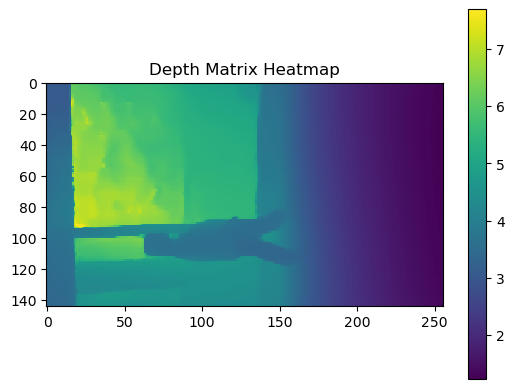

In [11]:
## Match frameA of openpose with frameB of lidar

frame_openpose = int(image_path.split('/')[-1].split('.')[0])
lidar_fps = 1/30
openpose_fps = 1/19.86
openpose_time = frame_openpose*openpose_fps
lidar_frame = round(  openpose_time/openpose_duration*lidar_duration/lidar_fps -2  )
print(lidar_frame,'\n',lidar_df.iloc[lidar_frame,1:5] )

# Depth image

depth_mtx = np.array(lidar_df.iloc[round(lidar_frame),1:]).reshape( 144 , 256)  # 144 row, 256 column    round(lidar_row)
plt.imshow(depth_mtx, cmap='viridis', interpolation='nearest')
plt.colorbar()  # 添加颜色条以显示深度值对应的颜色
plt.title('Depth Matrix Heatmap')
plt.show()

# 3D transformation of heel toe coordinate

In [24]:
heel_depth = depth_mtx[x_heel_lidar-1, y_heel_lidar-1]
toe_depth =  depth_mtx[x_toe_lidar-1,  y_toe_lidar-1 ]
Zc_heel = heel_depth * np.cos( np.arcsin(1.5/heel_depth) )
Zc_toe = toe_depth * np.cos( np.arcsin(1.5/toe_depth) ) 
heel_depth, toe_depth, Zc_heel, Zc_toe,

(3.316406, 3.445312, 2.9577945765106817, 3.1016406589648646)

In [25]:
Xc_heel = Zc_heel*(x_heel_lidar-avg_camera_mtx[0,2])/avg_camera_mtx[0,0]
Yc_heel = Zc_heel*(y_heel_lidar-avg_camera_mtx[1,2])/avg_camera_mtx[1,1]
Xc_toe = Zc_toe*(x_toe_lidar-avg_camera_mtx[0,2])/avg_camera_mtx[0,0]
Yc_toe = Zc_toe*(x_toe_lidar-avg_camera_mtx[1,2])/avg_camera_mtx[1,1]

sin_theta = abs(Yc_heel-Yc_toe)/(np.sqrt(  (Xc_heel-Xc_toe)**2+(Yc_heel-Yc_toe)**2+ (Zc_heel-Zc_toe)**2 )  )
theta = np.degrees(np.arcsin(sin_theta))
# theta = np.degrees(theta)
print('HS angle of frame %s is : %s'%(frame_openpose,theta))

HS angle of frame 87 is : 35.795929349353905
